# Part 1: Temporal Difference Error
* This is **not** in a loop. You will write the lines necessary for one update of a TD error
* In the markdown boxes explain what you're doing
* Create an environment

In [55]:
import gym
import atari_py
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter, deque
from itertools import chain
import seaborn as sns
import random


env = gym.make('CartPole-v0')
state = env.reset()

* Build a model 

In [56]:
actions = env.action_space
num_actions = env.action_space.n
epsilon = 0.9
states = []
gradients = []
rewards = []

agent = Sequential()
agent.add(Dense(24, input_shape=(4,), activation='relu', kernel_initializer='glorot_uniform'))
agent.add(Dense(24, activation='relu', kernel_initializer='glorot_uniform'))
agent.add(Dense(num_actions, activation='softmax', kernel_initializer='glorot_uniform'))
agent.compile(loss='categorical_crossentropy', optimizer='adam')
agent.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 24)                120       
_________________________________________________________________
dense_43 (Dense)             (None, 24)                600       
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


* Take an epsilon greedy action

In [57]:
if np.random.rand() <= epsilon:
    action = env.action_space.sample()
else:
    act_values = agent.predict(state)
    action = np.argmax(act_values[0])
    
action_probs = agent.predict(np.vstack([state]))
prob = action_probs / np.sum(action_probs)

* Observe the result from the environment

In [58]:
state, reward, done, info = env.step(action)

y = np.zeros([num_actions])
y[action] = 1                         # the action that was actually taken

gradients.append(y - prob)            # encourages the action that was taken to be taken
states.append(state)                  # store the state
rewards.append(reward)   

* Create the supervised target for your model

In [59]:
gamma = 0.90  # discounting factor
running_add = 0  # discounted total
discounted_rewards = np.zeros_like(rewards)

for t in reversed(range(len(rewards))): # start at end of episode 
    if rewards[t] != 0: 
        running_add = 0
        
    running_add = running_add * gamma + rewards[t] # discount reward
    discounted_rewards[t] = running_add

    
rewards = np.vstack(rewards)
gradients = np.vstack(gradients)


# there needs to be multiple samples otherwise rewards will be inf from the std
rewards = discounted_rewards / np.std(discounted_rewards - np.mean(discounted_rewards))

X = np.vstack(states)
Y = gradients * rewards

c:\users\ryank\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide


* Update weights (model.fit())

In [60]:
history = agent.fit(X, Y, batch_size=32, verbose=0)

# Part 2: Build a Deep Q Network
* Build an agent class with the following layout

In [175]:
class Agent:
    def __init__(self):
        self.num_actions = env.action_space.n
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = self.build_model()

    def act(self, state):
        if np.random.rand() <= self.epsilon: # If the random probability is less than the greed, pick random action
            return env.action_space.sample()
        
        # Otherwise use the model to predict the action
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
        
    def build_model(self):
        agent = Sequential()
        agent.add(Dense(24, input_shape=(4,), activation='relu', kernel_initializer='glorot_uniform'))
        agent.add(Dense(24, activation='relu', kernel_initializer='glorot_uniform'))
        agent.add(Dense(self.num_actions, activation='softmax', kernel_initializer='glorot_uniform'))
        agent.compile(loss='categorical_crossentropy', optimizer='adam')
        
        return agent
        
    def remember(self, state, action, reward, next_state, done):
        # env has a self memory so we just need to add to that
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size):
        # Taken from your code, but it just runs through a mini batch of the game 
        while(True):
            minibatch = random.sample(self.memory, batch_size)
            if(len(self.memory) > batch_size):
                break
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = np.reshape(next_state, [1, 4])
                # if there's a next state predict the q values of it
                target = reward + self.gamma * \
                       np.amax(self.model.predict(next_state)[0])

            # predict q values of state
            target_f = self.model.predict(state)
            # update the q value from the action that was taken
            target_f[0][action] = target
            # train
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [177]:
env = gym.make('CartPole-v0')
agent = Agent()
agent.model.summary()
rewards = []
episodes = 500

# Iterate the game
for e in range(episodes):
    # reset state in the beginning of each game
    state = env.reset()
    state = np.reshape(state, [1, 4])
    done  = False
    while not done:
        
        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        
        # Remember the previous state, action, reward, and done
        agent.remember(state, action, reward, next_state, done)
        next_state = np.reshape(next_state, [1, 4])
        
        # make next_state the new current state for the next frame
        state = next_state
        
        if done:
            # save reward from that episode
            rewards.append(reward)
            print("episode: {}/{}, score: {}".format(e, episodes, rewards[e]))
            break
            
    # train the agent with the experience of the episode
    print(len(agent.memory))
    agent.replay(32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_329 (Dense)            (None, 24)                120       
_________________________________________________________________
dense_330 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_331 (Dense)            (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
episode: 0/500, score: 1.0
36
episode: 1/500, score: 1.0
60
episode: 2/500, score: 1.0
96
episode: 3/500, score: 1.0
112
episode: 4/500, score: 1.0
128
episode: 5/500, score: 1.0
140
episode: 6/500, score: 1.0
167
episode: 7/500, score: 1.0
212
episode: 8/500, score: 1.0
229
episode: 9/500, score: 1.0
243
episode: 10/500, score: 1.0
276
episode: 11/500, score: 1.0
296
episode: 12/500, score: 1.0
322
episo

####  -Not sure why the reward doesn't change. It is using the env rewards so I have no part in that

# Part 3: Double Deep Q Network
* Implement a target DQN (only gets updated every $C$ episodes)
* Normal DQN (gets updated every episode)

In [201]:
class Agent:
    def __init__(self):
        self.num_actions = env.action_space.n
        self.memory = deque(maxlen=2000)
        self.target_memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.target_model = self.build_model()
        self.model        = self.build_model()
        
    def act(self, state):
        if np.random.rand() <= self.epsilon: # If the random probability is less than the greed, pick random action
            return env.action_space.sample()
        
        # Otherwise use the model to predict the action
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
        
        
    def build_model(self):
        agent = Sequential()
        agent.add(Dense(24, input_shape=(4,), activation='relu', kernel_initializer='glorot_uniform'))
        agent.add(Dense(24, activation='relu', kernel_initializer='glorot_uniform'))
        agent.add(Dense(self.num_actions, activation='softmax', kernel_initializer='glorot_uniform'))
        agent.compile(loss='categorical_crossentropy', optimizer='adam')
        
        return agent
        
    def remember(self, state, action, reward, next_state, done):
        self.target_memory.append((state, action, reward, next_state, done))
        self.memory.append((state, action, reward, next_state, done))
    
    def replay(self, batch_size): # I couldn't figure out what would be the difference between the replay of a DQN and DDQN
        while(True):
            minibatch = random.sample(self.memory, batch_size)
            if(len(self.memory) > batch_size):
                break
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                next_state = np.reshape(next_state, [1, 4])
                # if there's a next state predict the q values of it
                target = reward + self.gamma * \
                       np.amax(self.target_model.predict(next_state)[0])

            # predict q values of state
            target_f = self.model.predict(state)
            # update the q value from the action that was taken
            target_f[0][action] = target
            # train
            self.model.fit(state, target_f, epochs=1, verbose=0)
            self.target_model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [210]:
env = gym.make('CartPole-v0')
agent = Agent()
agent.model.summary()
double_rewards = []
episodes = 500
C = 10

# Iterate the game
for e in range(episodes):
    # reset state in the beginning of each game
    state = env.reset()
    state = np.reshape(state, [1, 4])
    done  = False
    while not done:
        
        action = agent.act(state)
        
        next_state, reward, done, _ = env.step(action)
        
        # Remember the previous state, action, reward, and done
        agent.remember(state, action, reward, next_state, done)
        next_state = np.reshape(next_state, [1, 4])
        
        # make next_state the new current state for the next frame
        state = next_state
        
        if done:
            # save reward from that episode
            double_rewards.append(reward)
            print("episode: {}/{}, score: {}".format(e, episodes, rewards[e]))
            break
            
    # train the agent with the experience of a group of episodes
    if(e // 10 == 0):
        agent.replay(32)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_491 (Dense)            (None, 24)                120       
_________________________________________________________________
dense_492 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_493 (Dense)            (None, 2)                 50        
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
episode: 0/500, score: 1.0
episode: 1/500, score: 1.0
episode: 2/500, score: 1.0
episode: 3/500, score: 1.0
episode: 4/500, score: 1.0
episode: 5/500, score: 1.0
episode: 6/500, score: 1.0
episode: 7/500, score: 1.0
episode: 8/500, score: 1.0
episode: 9/500, score: 1.0
episode: 10/500, score: 1.0
episode: 11/500, score: 1.0
episode: 12/500, score: 1.0
episode: 13/500, score: 1.0
episode: 14/500, score: 1.

# Plots
* Show the reward over time from part 2 and 3 on the same plot

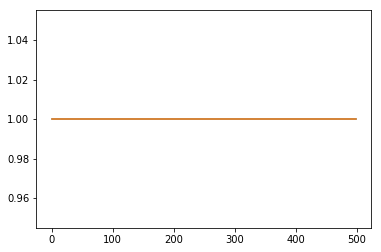

In [213]:
# It would be easy to do if the models ran properly

plt.subplot(111)
plt.plot(rewards)
plt.plot(double_rewards)
plt.show()